# Load Libraries

In [76]:
import pandas as pd
import numpy as np
import random
import os
import datetime

# 시각화 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# font
plt.rc('font', family='AppleGothic')

# machine learning
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler


# Fixed Random Seed

In [77]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# Load Dataset

In [78]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

display(train_df.head(3))
display(test_df.head(3))

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0


# 데이터 전처리 1 : 학습 및 추론 데이터 설정¶

모델에게 입력할 학습 데이터와 추론 데이터를 만들어 봅시다



In [79]:
train_x = train_df.drop(columns=['ID', '대출등급'])
train_y = train_df['대출등급']

test_x = test_df.drop(columns=['ID'])

# Visualization

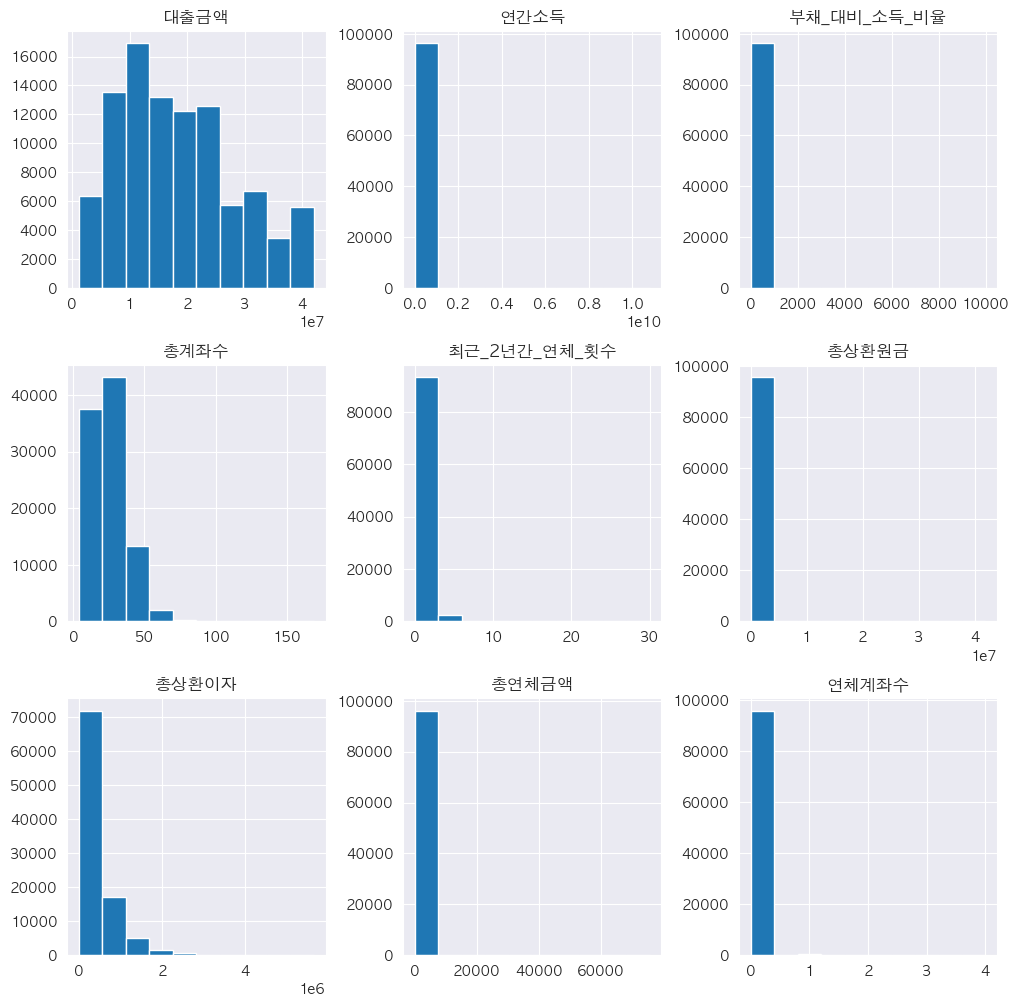

In [80]:
target = train_x.hist(figsize=(12,12))
plt.show()

# 데이터 전처리 2-1 : 범주형 변수 수치화 (근로기간, 대출기간)¶

#### LabelEncoder를 통해 범주형 변수 수치화 진행

In [81]:
# '근로기간' 컬럼 데이터 매핑
mapping = {
    '6 years': 6,
    '10+ years': 10,
    '5 years': 5,
    '8 years': 8,
    'Unknown': 0,
    '9 years': 9,
    '2 years': 2,
    '1 year': 1,
    '3 years': 3,
    '7 years': 7
}

# '근로기간' 컬럼을 숫자로 변환
train_x['근로기간'] = train_x['근로기간'].map(mapping)
test_x['근로기간'] = test_x['근로기간'].map(mapping)

In [82]:
# 대출기간
train_x['대출기간'] = train_x['대출기간'].str.extract('(\d+)').astype(int)
test_x['대출기간'] = test_x['대출기간'].str.extract('(\d+)').astype(int)

# 데이터 전처리 2-2 : 범주형 변수 수치화¶

#### LabelEncoder를 통해 범주형 변수 수치화 진행

In [83]:
categorical_features = ['주택소유상태', '대출목적']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x[i]) 
    train_x[i]=le.transform(train_x[i])
    
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test_x[i]=le.transform(test_x[i])

display(train_x.head(3))
display(test_x.head(3))

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,36,6.0,3,72000000,18.90,15,1,0,0,0.0,0.0,0.0
1,14400000,60,10.0,1,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0
2,12000000,36,5.0,1,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,36,8.0,1,132000000,19.64,12,10,0,394692,146604.0,0.0,0.0
1,8400000,36,5.0,3,89971200,15.84,25,1,0,0,0.0,0.0,0.0
2,17280000,36,6.0,3,150000000,8.41,20,3,0,1786980,281820.0,0.0,0.0


# 데이터 전처리 3 : 수치형 변수 전처리

#### 

# 새로운 피쳐 생성

1. 연간소득 대비 대출금액 비율
2. 대출금액 대비 총상환원금+총상환이자
3. 총상환이자/총상환원금

In [84]:
# '연간소득'이 0인 경우를 NaN으로 대체
train_x['연간소득'] = train_x['연간소득'].replace(0, np.nan)
test_x['연간소득'] = test_x['연간소득'].replace(0, np.nan)

In [85]:
# 연간소득 대비 대출금액 비율
train_x['대출금액_연간소득_비율'] = train_x['대출금액'] / train_x['연간소득']
test_x['대출금액_연간소득_비율'] = test_x['대출금액'] / test_x['연간소득']

In [86]:
# 연간소득 대비 총상환원금+총상환이자
train_x['총상환현금_연간소득_비율'] = (train_x['총상환원금']+train_x['총상환이자']) / train_x['대출금액']
test_x['총상환현금_연간소득_비율'] = (test_x['총상환원금']+test_x['총상환이자']) / test_x['대출금액']

In [87]:
# 총상환이자/총상환원금
train_x['이자비율'] = train_x['총상환이자'] / train_x['총상환원금']
test_x['이자비율'] = test_x['총상환이자'] / test_x['총상환원금']

# '이자비율'이 inf인 경우를 NaN으로 대체
train_x['이자비율'].replace([np.inf, -np.inf], np.nan, inplace=True)
test_x['이자비율'].replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 0으로 대체
train_x['이자비율'].fillna(0, inplace=True)
test_x['이자비율'].fillna(0, inplace=True)

In [88]:
# 연체계좌비율
train_x['연체계좌비율'] = train_x['연체계좌수'] / train_x['총계좌수']
test_x['연체계좌비율'] = test_x['연체계좌수'] / test_x['총계좌수']

# 필요없는 피쳐 정리

In [90]:
train_x = train_x.drop(columns=['총상환원금', '총상환이자', '총계좌수'])
test_x = test_x.drop(columns=['총상환원금', '총상환이자', '총계좌수'])

# 데이터 확인

In [89]:
display(train_x.head(3))
display(test_x.head(3))

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출금액_연간소득_비율,총상환현금_연간소득_비율,이자비율,연체계좌비율
0,12480000,36,6.0,3,72000000.0,18.90,15,1,0,0,0.0,0.0,0.0,0.173333,0.000000,0.000000,0.0
1,14400000,60,10.0,1,130800000.0,22.33,21,10,0,373572,234060.0,0.0,0.0,0.110092,0.042197,0.626546,0.0
2,12000000,36,5.0,1,96000000.0,8.60,14,1,0,928644,151944.0,0.0,0.0,0.125000,0.090049,0.163619,0.0


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출금액_연간소득_비율,총상환현금_연간소득_비율,이자비율,연체계좌비율
0,16800000,36,8.0,1,132000000.0,19.64,12,10,0,394692,146604.0,0.0,0.0,0.127273,0.032220,0.371439,0.0
1,8400000,36,5.0,3,89971200.0,15.84,25,1,0,0,0.0,0.0,0.0,0.093363,0.000000,0.000000,0.0
2,17280000,36,6.0,3,150000000.0,8.41,20,3,0,1786980,281820.0,0.0,0.0,0.115200,0.119722,0.157707,0.0


# 스케일링

이상치가 많은 데이터에는 로버스트 스케일링이 유리할 수 있고, 데이터의 분포가 정규분포를 따른다고 가정하는 모델(예: 선형 회귀, 로지스틱 회귀)에는 표준화가 적합할 수 있습니다. 반면, 거리 기반의 알고리즘(예: k-NN, SVM)을 사용할 때는 정규화를 고려할 수 있습니다.

1. 표준화 (Standardization) : 데이터의 평균을 0, 표준편차를 1로 만든다. StandardScaler.
2. 정규화 (Normalization) : 데이터의 값을 0과 1 또는 -1과 1 사이의 범위로 조정한다. MinMaxScaler.
3. 로버스트 스케일링 (Robust Scaling) : 이상치의 영향을 최소화하면서 데이터의 중앙값을 0으로, IQR을 1로 조정한다. RobustScaler

In [91]:
# scaler = RobustScaler()

In [91]:
display(train_x.head(3))
display(test_x.head(3))

# train_y 인코딩

In [92]:
# train_y 문자열 레이블 숫자로 인코딩
le = LabelEncoder()
le=le.fit(train_y)
train_y=le.transform(train_y)

# 모델 선정 및 학습¶

대출등급 분류를 위한 AI 모델을 정하고 학습시켜 봅시다

In [93]:
# model = RandomForestClassifier()
model = xgb.XGBClassifier(objective='multi:softmax', num_class=7)
model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

# 예측 수행

.predict()를 통해 모델이 예측한 대출등급을 구해봅시다

In [94]:
pred = model.predict(test_x)

In [95]:
# 레이블 디코딩
decoded_labels = le.inverse_transform(pred)

# 제출양식에 예측결과 입력¶

모델이 예측한 대출등급을 제출양식에 입력해 봅시다

In [96]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['대출등급'] = decoded_labels
sample_submission

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


# 예측결과 저장

값이 기입된 제출물을 저장해 봅시다

In [97]:
# 현재 날짜와 시간 정보 가져오기
current_datetime = datetime.datetime.now()

# 파일 이름 형식 지정 (연월일_시간)
file_name = f'xgb_{current_datetime.strftime("%Y%m%d_%H%M")}.csv'

# 파일 이름 출력
print(file_name)

xgb_20240122_2323.csv


In [98]:
sample_submission.to_csv('result/'+file_name,index=False)